# Lab 2 - LDPC

In [3]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from numba import njit
import networkx as nx

---
## Projeção de matriz de verificação de paridade para um código LPDC regular
Gere um programa que seja capaz de projetar a matriz de verificação de paridade para um código LDPC regular para valores arbitrários de $d_v$, $d_c$ e $N$.

In [4]:
# Define a function to set the parameters
@njit
def set_params(N: int, dv: int, dc: int) -> tuple[int, int]:
    if (N  % dc != 0):
        raise ValueError("N must be divisible by dc")
    else:
        K = int(N / dc)
        M = int(K * dv)
        return (K, M)

In [5]:
# Example
N = 999
dv = 4
dc = 9
K, M = set_params(N, dv, dc)
K, M

(111, 444)

In [6]:
# Define a function to generate a LDPC matrix // graph
@njit
def generate_LDPC_matrix(N: int, dv: int, dc: int, K: int, M: int) -> np.array:
    H1 = np.zeros((K, N), dtype = np.int32)
    for i in range(len(H1)):
        H1[i][i*dc:(i+1)*dc] = 1
    
    H = H1

    for _ in range(dv - 1):
        # Generate a random permutation of the H1 columns
        perm = np.random.permutation(N)
        H2 = H1[:, perm]
        H = np.concatenate((H, H2), axis=0)

    return H

In [7]:
# Example
H = generate_LDPC_matrix(N, dv, dc, K, M)
H.shape, H

((444, 999),
 array([[1, 1, 1, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]))

### Visualização em Grafo

In [8]:
# Using the nx.Graph to visualize the bipartite graph from H matrix
def plot_bipartite_graph(H: np.array):
    G = nx.Graph()
    N, M = H.shape
    for i in range(N):
        for j in range(M):
            if H[i][j] == 1:
                G.add_edge(f'c{i}', f'v{j}')
    
    pos = {}
    for i in range(N):
        pos[f'c{i}'] = (i, 0)
    
    for i in range(M):
        pos[f'v{i}'] = (i, 1)
    
    nx.draw(G, pos, with_labels=True, node_size=500, font_size=10)
    plt.show()


In [9]:
H = np.array([[1, 1, 0, 1, 0, 0],
              [1, 0, 1, 0, 1, 0],
              [0, 1, 1, 0, 0, 1],
              [0, 0, 0, 1, 1, 1]])

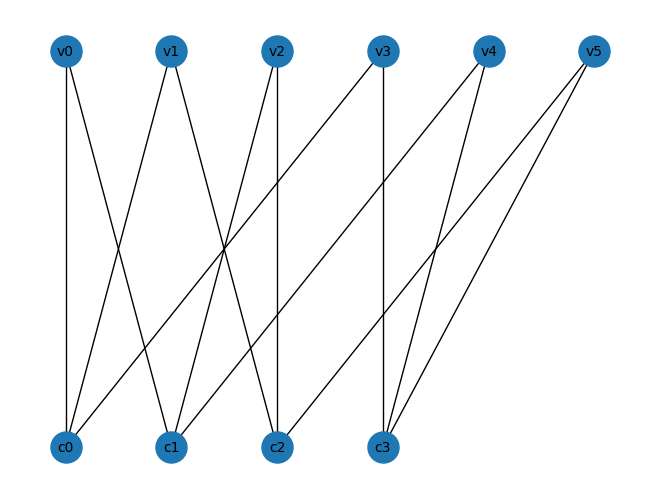

In [10]:
# Example
plot_bipartite_graph(H)

---
## Projeção de matrizes de com taxa idêntica ao código de Hamming
Utilize o programa do item acima para projetar matrizes de verificação de paridade com taxa idêntica ao código de Hamming mas com comprimentos de aproximadamente 100, 200, 500 e 1000 bits. Use o valor de N correto mais próximo destes valores.

Para a mesma taxa do código de Hamming (4/7), a taxa $d_v/d_c = 3/7$

In [11]:
set_params(1001, 3, 7)

(143, 429)

In [12]:
N_list = [98, 203, 497, 1001]

---
## Implementação de um decodificador
Implemente um decodificador que, com base na matriz de verificação de paridade, seja capaz de realizar o processo iterativo conforme o algoritmo bit-flipping. Aproveite da "esparsidade" da matriz de verificação de paridade para reduzir a complexidade.

In [13]:
# Define a function for the parity check matrix
@njit
def parity_check(H: np.array, y: np.array) -> np.array:
    s = np.zeros(H.shape[0], dtype = np.int32)

    for i in range(len(H)):
        s[i] = np.sum(H[i] * y) % 2
    
    return s

# Define a function for the bit-flipping algorithm to decode the message
@njit
def bit_flipping(H: np.array, y: np.array, max_iter: int) -> np.array:
    iteration = 0
    x = y.copy()
    column_length = H.shape[1]
    errors = np.ones(column_length, dtype = np.int32)

    s = parity_check(H, x)

    while np.sum(s) != 0 and iteration <= max_iter:
        for i in range(column_length):
            errors[i] = np.sum(H[:, i] * s)

        for i in range(len(errors)):
            if errors[i] == np.max(errors):
                x[i] ^= 1    

        s = parity_check(H, x)
        iteration += 1

    return x

In [14]:
# Example
test_vector = np.array([1, 0, 0, 1, 0, 0])
e = bit_flipping(H, test_vector, 10)
e

array([1, 0, 0, 1, 1, 0])

---
## Estimar probabilidade de erro

Estime a probabilidade de erro de bit de informação para os 4 sistemas encontrados considerando que a palavra código é transmitida através de um canal BSC com parâmetro p = 0.1, 0.05, 0.002, 0.001, ....0.00001. Dica: a probabilidade de erro de bit é uniforme para todos os bits da palavra código.

### BSC definition

In [15]:
# Define a function for a Binary Symmetric Channel with parameter p
@njit
def bsc(input_vector: np.ndarray, p: float) -> np.ndarray:
    # Generate a random vector with the same length as the input vector
    random_vector = np.random.rand(input_vector.shape[0])
    # Apply the channel to the input vector
    output_vector = (input_vector + (random_vector < p)) % 2
    return output_vector

In [16]:
# Test the bsc
input = np.array([0, 1, 1, 0])
output = bsc(input, 0.08)
output

array([0, 1, 1, 0], dtype=int64)

### Estimation for BSC channel

In [17]:
# Sample_size is defined to be 1 million -> check Chebyshev inequality after
@njit
def bsc_pb_est(p: float) -> float:
    sample_size = 1_000_000
    error_count = 0
    k = 1
    l = int(sample_size/k)

    for _ in range(l):
        input_vector = np.zeros(k, dtype=np.int32)
        output_vector = bsc(input_vector, p)
        error_count += np.count_nonzero(input_vector != output_vector)

    return error_count/sample_size

In [18]:
bsc_pb_est(0.05)

0.050322

### Estimation for Bit-Flipping (different N values)

In [19]:
@njit
def ham_bit_flip_pb_est(p: float, N: int, dv: int, dc: int) -> float:
    K, M = set_params(N, dv, dc)
    sample_size = 1_000_000.
    error_count = 0.
    k = N
    l = int(sample_size/k)
    num_of_bits = l * k

    for _ in range(l):
        LDPC_matrix = generate_LDPC_matrix(N, dv, dc, K, M)
        input_vector = np.zeros(k, dtype = np.int32)        
        output_vector = bsc(input_vector, p)
        decoded_vector = bit_flipping(LDPC_matrix, output_vector, 10)
        error_count += np.count_nonzero(input_vector != decoded_vector)

    return error_count/num_of_bits

In [20]:
N = N_list[0]
dv = 3
dc = 7

In [21]:
ham_bit_flip_pb_est(0.005, N, dv, dc)

0.0026040208321666575

In [22]:
p_list = np.linspace(0.1, 1e-5, 100)

In [23]:
# 5 seconds for 20 points
error_results_bsc_njit = [bsc_pb_est(p_i) for p_i in p_list]

In [24]:
# Save the error_results_bsc_njit array
np.save('error_results_bsc_njit5.npy', error_results_bsc_njit)

In [25]:
# 14 seconds for 20 points
dv = 3
dc = 7
error_results_ham_100_njit = [ham_bit_flip_pb_est(p_i, N_list[0], dv, dc) for p_i in p_list]

In [26]:
# Save the error_results_ham_100_njit array
np.save('error_results_ham_100_njit5.npy', error_results_ham_100_njit)

In [27]:
dv = 3
dc = 7
error_results_ham_200_njit = [ham_bit_flip_pb_est(p_i, N_list[1], dv, dc) for p_i in p_list]

In [28]:
# Save the error_results_ham_200_njit array
np.save('error_results_ham_200_njit5.npy', error_results_ham_200_njit)

In [29]:
dv = 3
dc = 7
error_results_ham_500_njit = [ham_bit_flip_pb_est(p_i, N_list[2], dv, dc) for p_i in p_list]

In [30]:
# Save the error_results_ham_500_njit array
np.save('error_results_ham_500_njit5.npy', error_results_ham_500_njit)

In [31]:
dv = 3
dc = 7
error_results_ham_1000_njit = [ham_bit_flip_pb_est(p_i, N_list[3], dv, dc) for p_i in p_list]

In [32]:
# Save the error_results_ham_1000_njit array
np.save('error_results_ham_1000_njit5.npy', error_results_ham_1000_njit)

### Estimation for 1/2

In [33]:
N_list_1_2 = [100, 200, 500, 1000]

In [37]:
dv = 1
dc = 2
error_results_ham_100_1_2_njit = [ham_bit_flip_pb_est(p_i, N_list_1_2[0], dv, dc) for p_i in p_list]

np.save('error_results_ham_100_1_2_njit5.npy', error_results_ham_100_1_2_njit)

In [38]:
dv = 1
dc = 2
error_results_ham_200_1_2_njit = [ham_bit_flip_pb_est(p_i, N_list_1_2[1], dv, dc) for p_i in p_list]

np.save('error_results_ham_200_1_2_njit5.npy', error_results_ham_200_1_2_njit)

In [39]:
dv = 1
dc = 2
error_results_ham_500_1_2_njit = [ham_bit_flip_pb_est(p_i, N_list_1_2[2], dv, dc) for p_i in p_list]

np.save('error_results_ham_500_1_2_njit5.npy', error_results_ham_500_1_2_njit)

In [40]:
dv = 1
dc = 2
error_results_ham_1000_1_2_njit = [ham_bit_flip_pb_est(p_i, N_list_1_2[3], dv, dc) for p_i in p_list]

np.save('error_results_ham_1000_1_2_njit5.npy', error_results_ham_1000_1_2_njit)

### Estimation for 1/3

In [41]:
N_list_1_3 = [99, 201, 501, 999]

In [42]:
dv = 2
dc = 3
error_results_ham_100_2_3_njit = [ham_bit_flip_pb_est(p_i, N_list_1_3[0], dv, dc) for p_i in p_list]

np.save('error_results_ham_100_2_3_njit5.npy', error_results_ham_100_2_3_njit)

In [43]:
dv = 2
dc = 3
error_results_ham_200_2_3_njit = [ham_bit_flip_pb_est(p_i, N_list_1_3[1], dv, dc) for p_i in p_list]

np.save('error_results_ham_200_2_3_njit5.npy', error_results_ham_200_2_3_njit)

In [44]:
dv = 2
dc = 3
error_results_ham_500_2_3_njit = [ham_bit_flip_pb_est(p_i, N_list_1_3[2], dv, dc) for p_i in p_list]

np.save('error_results_ham_500_2_3_njit5.npy', error_results_ham_500_2_3_njit)

In [45]:
dv = 2
dc = 3
error_results_ham_1000_2_3_njit = [ham_bit_flip_pb_est(p_i, N_list_1_3[3], dv, dc) for p_i in p_list]

np.save('error_results_ham_1000_2_3_njit5.npy', error_results_ham_1000_2_3_njit)

### Estimation for Hamming (4/7)

In [46]:
# Defining a function as a Hamming coder
def hamming_coder(input_vector: np.ndarray) -> np.ndarray:
    # Defining a parity matrix
    G = np.array([[1, 0, 0, 0, 1, 1, 1],
                  [0, 1, 0, 0, 1, 0, 1],
                  [0, 0, 1, 0, 1, 1, 0],
                  [0, 0, 0, 1, 0, 1, 1]], dtype=np.int32)
    # Encoding the input vector
    output_vector = np.dot(input_vector, G) % 2
    return output_vector

def syndrome(input_vector: np.ndarray) -> np.ndarray:
    # Defining a parity-check matrix
    H = np.array([[1, 1, 1, 0, 1, 0, 0],
                  [1, 0, 1, 1, 0, 1, 0],
                  [1, 1, 0, 1, 0, 0, 1]], dtype=np.int32)
    # Decoding the input vector
    output_vector = np.dot(input_vector, H.T) % 2
    return output_vector

s_dict = {
    '0': (np.array([0, 0, 0]), np.array([0, 0, 0, 0, 0, 0, 0])),
    '1': (np.array([1, 1, 1]), np.array([1, 0, 0, 0, 0, 0, 0])),
    '2': (np.array([1, 0, 1]), np.array([0, 1, 0, 0, 0, 0, 0])),
    '3': (np.array([1, 1, 0]), np.array([0, 0, 1, 0, 0, 0, 0])),
    '4': (np.array([0, 1, 1]), np.array([0, 0, 0, 1, 0, 0, 0])),
    '5': (np.array([1, 0, 0]), np.array([0, 0, 0, 0, 1, 0, 0])),
    '6': (np.array([0, 1, 0]), np.array([0, 0, 0, 0, 0, 1, 0])),
    '7': (np.array([0, 0, 1]), np.array([0, 0, 0, 0, 0, 0, 1]))
}

# Calculating the e_prime from syndrome
def e_prime_calc(s: np.ndarray) -> np.ndarray:
    for s_index in s_dict.items():
        if np.array_equal(s_index[1][0], s):
            return s_index[1][1]
        
# Defining the Hamming decoder function with 1-bit correction
def hamming_decoder(input_vector: np.ndarray) -> np.ndarray:
    s = syndrome(input_vector)
    e_prime = e_prime_calc(s)
    decoded = (input_vector + e_prime) % 2
    return decoded[:4]

In [47]:
# Test the syndrome calculator
input = np.array([1, 0, 1, 1])
coded_input = hamming_coder(input)
coded_input

array([1, 0, 1, 1, 0, 1, 0], dtype=int32)

In [48]:
test = np.array([0, 0, 1, 0, 0, 0, 0])
s = syndrome(test)
s

array([1, 1, 0], dtype=int32)

In [49]:
test = np.array([1,0,0,0,0,0,1])
output_test = hamming_decoder(test)
output_test

array([1, 0, 1, 0], dtype=int32)

In [50]:
def hamming_pb_est(p: float) -> float:
    sample_size = 1_000_000
    error_count = 0
    k = 4
    l = int(sample_size/k)
    num_of_bits = l * k

    for _ in range(l):
        input_vector = np.zeros(k, dtype = np.int32)
        input_decoded = hamming_coder(input_vector)
        transmitted_vector = bsc(input_decoded, p)
        decoded_vector = hamming_decoder(transmitted_vector)
        error_count += np.count_nonzero(input_vector != decoded_vector)

    return error_count/num_of_bits

In [51]:
hamming_pb_est(0.05)

0.019208

In [52]:
error_results_hamming = [hamming_pb_est(p_i) for p_i in p_list]

In [53]:
# Save the error_results_hamming array
np.save('error_results_hamming.npy', error_results_hamming)

---
### Graph plot

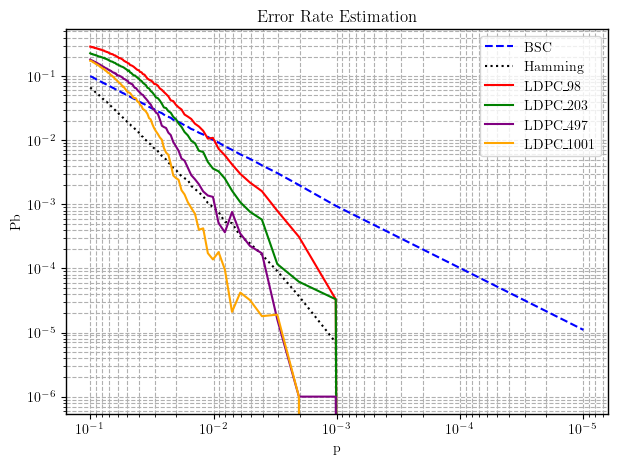

In [54]:
# Make a log plot of p vs. the estimated error rate
matplotlib.font_manager._load_fontmanager(try_read_cache=False)
plt.rcParams['font.family'] = "CMU Serif"
plt.rcParams['text.usetex'] = True
plt.rcParams['axes.linewidth'] = 1.0
fig, ax = plt.subplots(figsize=(7, 5))
ax.plot(p_list, error_results_bsc_njit, label="BSC", color='blue', linestyle='dashed')
ax.plot(p_list, error_results_hamming, label="Hamming", color='black', linestyle='dotted')
ax.plot(p_list, error_results_ham_100_njit, label="LDPC_98", color='red')
ax.plot(p_list,error_results_ham_200_njit, label="LDPC_203", color='green')
ax.plot(p_list,error_results_ham_500_njit, label="LDPC_497", color='purple')
ax.plot(p_list,error_results_ham_1000_njit, label="LDPC_1001", color='orange')
ax.grid(True, which="both", ls="--")
# Set xlims
#ax.set_xlim(5e-4, 0.11)
#ax.set_ylim(1e-7, 8e-1)
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend(loc = 0)
ax.set_xlabel('p')
ax.set_ylabel('Pb')
ax.set_title("Error Rate Estimation")
plt.gca().invert_xaxis()
plt.savefig('error_rate_estimation3.pdf')
plt.show()

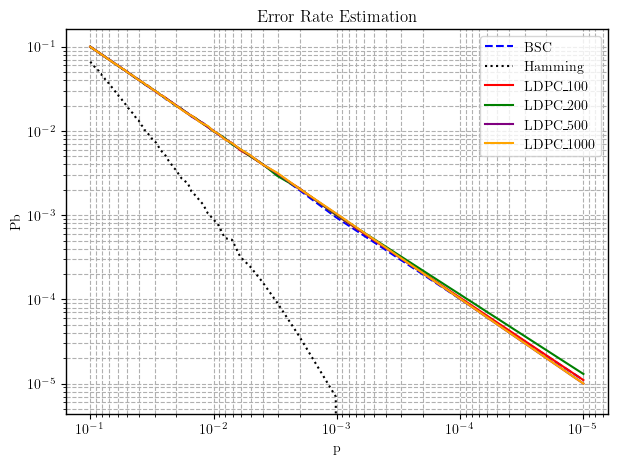

In [55]:
# Make a log plot of p vs. the estimated error rate
matplotlib.font_manager._load_fontmanager(try_read_cache=False)
plt.rcParams['font.family'] = "CMU Serif"
plt.rcParams['text.usetex'] = True
plt.rcParams['axes.linewidth'] = 1.0
fig, ax = plt.subplots(figsize=(7, 5))
ax.plot(p_list, error_results_bsc_njit, label="BSC", color='blue', linestyle='dashed')
ax.plot(p_list, error_results_hamming, label="Hamming", color='black', linestyle='dotted')
ax.plot(p_list, error_results_ham_100_1_2_njit, label="LDPC_100", color='red')
ax.plot(p_list,error_results_ham_200_1_2_njit, label="LDPC_200", color='green')
ax.plot(p_list,error_results_ham_500_1_2_njit, label="LDPC_500", color='purple')
ax.plot(p_list,error_results_ham_1000_1_2_njit, label="LDPC_1000", color='orange')
ax.grid(True, which="both", ls="--")
# Set xlims
#ax.set_xlim(5e-4, 0.11)
#ax.set_ylim(1e-7, 8e-1)
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend(loc = 0)
ax.set_xlabel('p')
ax.set_ylabel('Pb')
ax.set_title("Error Rate Estimation")
plt.gca().invert_xaxis()
plt.savefig('error_rate_estimation3.pdf')
plt.show()

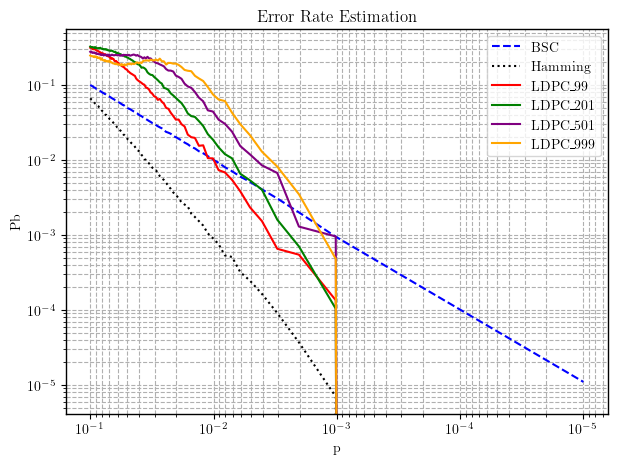

In [57]:
# Make a log plot of p vs. the estimated error rate
matplotlib.font_manager._load_fontmanager(try_read_cache=False)
plt.rcParams['font.family'] = "CMU Serif"
plt.rcParams['text.usetex'] = True
plt.rcParams['axes.linewidth'] = 1.0
fig, ax = plt.subplots(figsize=(7, 5))
ax.plot(p_list, error_results_bsc_njit, label="BSC", color='blue', linestyle='dashed')
ax.plot(p_list, error_results_hamming, label="Hamming", color='black', linestyle='dotted')
ax.plot(p_list, error_results_ham_100_2_3_njit, label="LDPC_99", color='red')
ax.plot(p_list,error_results_ham_200_2_3_njit, label="LDPC_201", color='green')
ax.plot(p_list,error_results_ham_500_2_3_njit, label="LDPC_501", color='purple')
ax.plot(p_list,error_results_ham_1000_2_3_njit, label="LDPC_999", color='orange')
ax.grid(True, which="both", ls="--")
# Set xlims
#ax.set_xlim(5e-4, 0.11)
#ax.set_ylim(1e-7, 8e-1)
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend(loc = 0)
ax.set_xlabel('p')
ax.set_ylabel('Pb')
ax.set_title("Error Rate Estimation")
plt.gca().invert_xaxis()
plt.savefig('error_rate_estimation3.pdf')
plt.show()